In [2]:
# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Clustering and distance metrics
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model evaluation
from sklearn.metrics import silhouette_score

# Pipeline and dimensionality reduction
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Elbow method for KMeans
from yellowbrick.cluster import KElbowVisualizer

In [3]:
df = pd.read_csv('data-model').drop(columns=['Unnamed: 0'])

df = df.dropna()
df = df.head(100)

df_num = df.select_dtypes(include="number")
df_num = df_num[['Income', 'Age', 'Children', 'TotalPurchases']]

df_num.head()

,Income,Age,Children,TotalPurchases
0,58138,57,0,25
1,46344,60,2,6
2,71613,49,0,21
3,26646,30,1,8
4,58293,33,1,19


In [8]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'lloyd')
kmeans.fit(df_num)

df['grupo'] = kmeans.labels_.astype('str')
#sns.pairplot(df, hue='grupo')

## Padronizando os dados e aplicando o K-Means

In [9]:
padronizador = StandardScaler()
df_padronizado = padronizador.fit_transform(df_num)

In [14]:
# Separar as colunas numéricas e categóricas
num_features = list(df.select_dtypes('number').columns)
cat_features = list(df.drop(columns=['grupo', 'Date', 'Dt_Customer']).select_dtypes('object').columns)

In [15]:
# Utilizamos OneHotEncoder para as variáveis categóricas e StandardScaler para as numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)  # Drop='first' para evitar multicolinearidade
    ])

In [16]:
X_preprocessed = preprocessor.fit_transform(df)

In [20]:
kmeans.fit(X_preprocessed)
df['grupo'] = kmeans.labels_

In [22]:
df.grupo.value_counts()

grupo
1    49
2    26
0    25
Name: count, dtype: int64

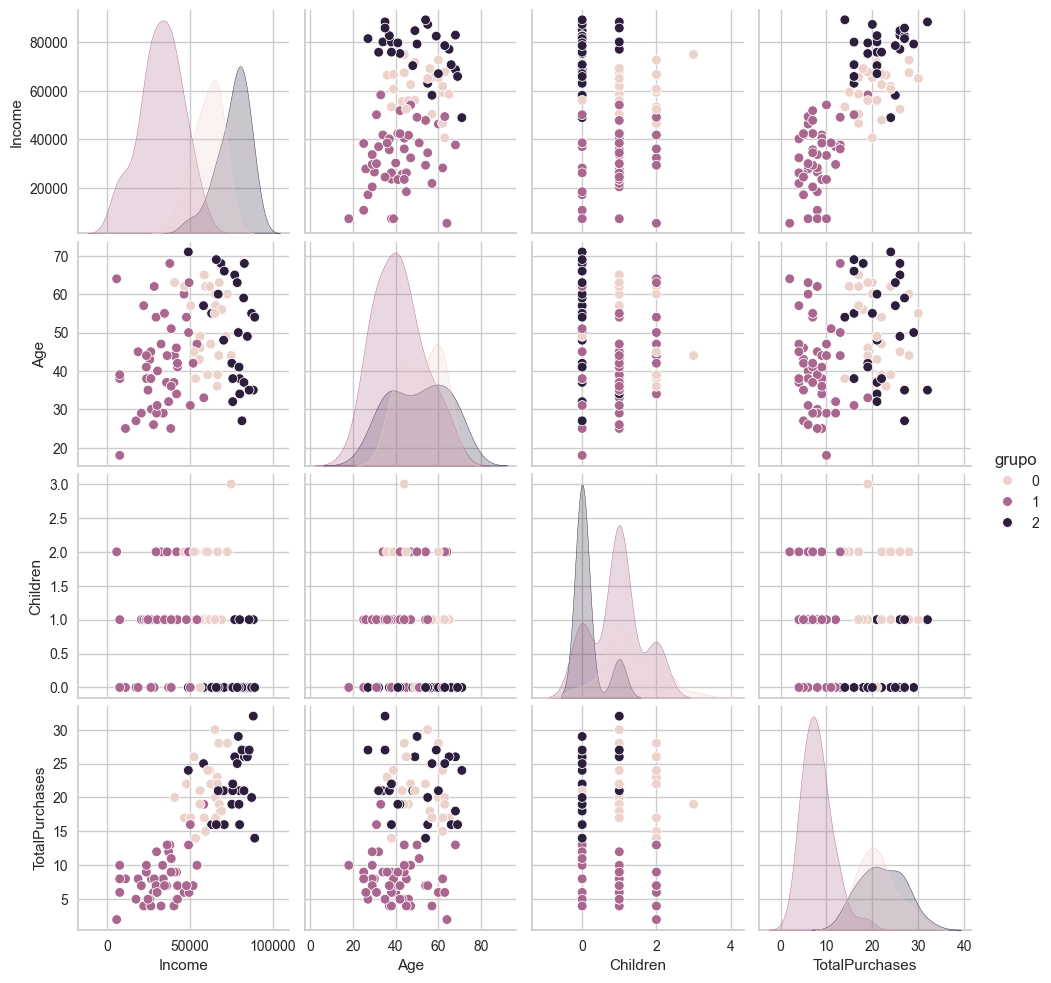

In [29]:
sns.pairplot(df[['Income', 'Age', 'Children', 'TotalPurchases', 'grupo']], hue='grupo')

## Método do cotovelo

In [15]:
# Elbow
def calcular_inercia(X, max_clusters=10):
    inercia = []
    for k in range(2, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inercia.append(kmeans.inertia_)
    return inercia

## Coeficiente de Silueta

In [16]:
# Silhouette
def calcular_silhouette(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    return silhouette_scores

## Estratégia de análise

In [17]:
inercia = calcular_inercia(X_preprocessed)
silhouette_scores = calcular_silhouette(X_preprocessed)

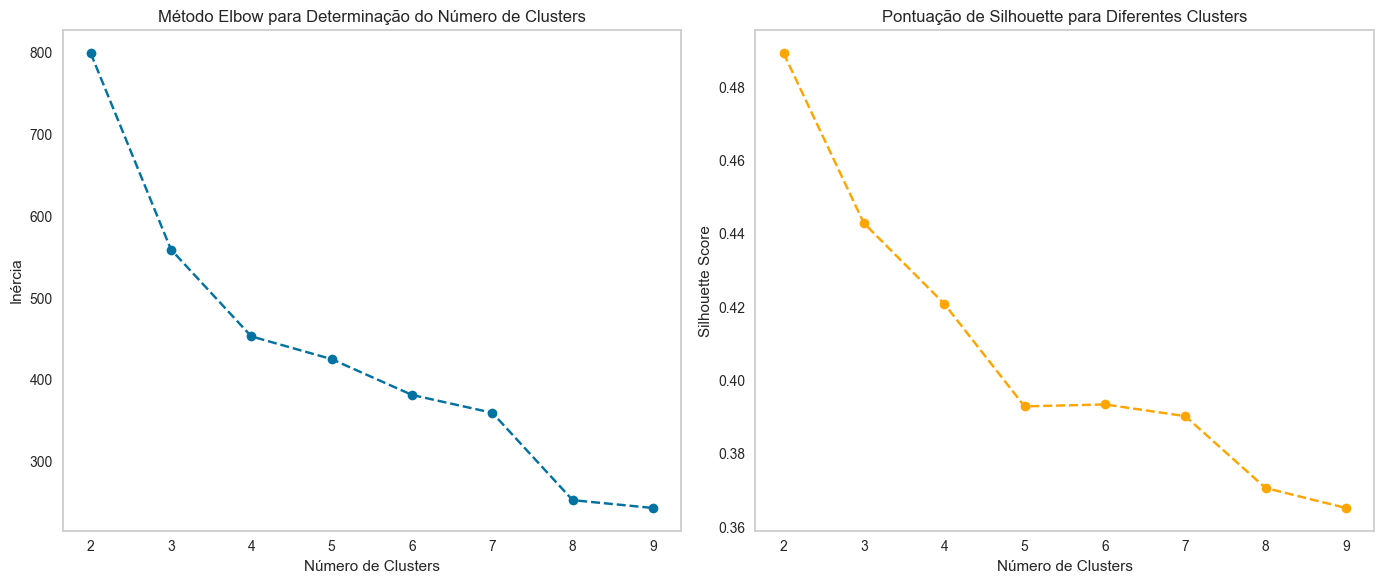

In [18]:
# Plotar o gráfico
plt.figure(figsize=(14, 6))

# Gráfico do método Elbow
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inercia, marker='o', linestyle='--')
plt.title('Método Elbow para Determinação do Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid()

# Gráfico da Pontuação de Silhouette
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Pontuação de Silhouette para Diferentes Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()

plt.tight_layout()
plt.show()

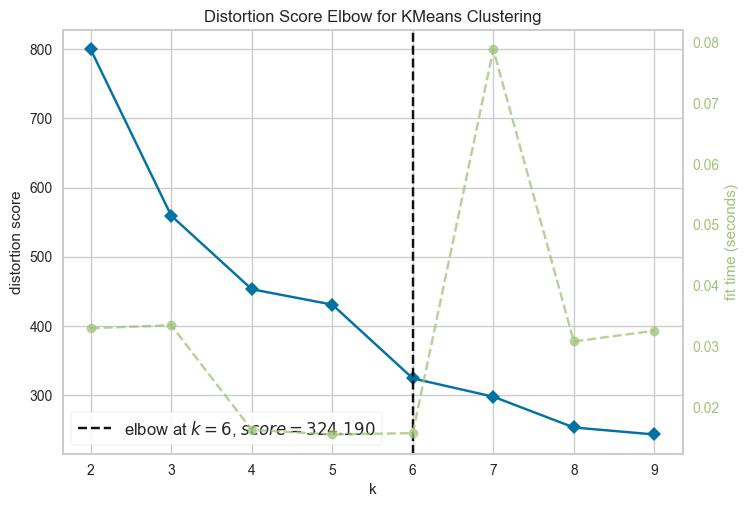

In [19]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_preprocessed)
visualizer.show()
plt.show()

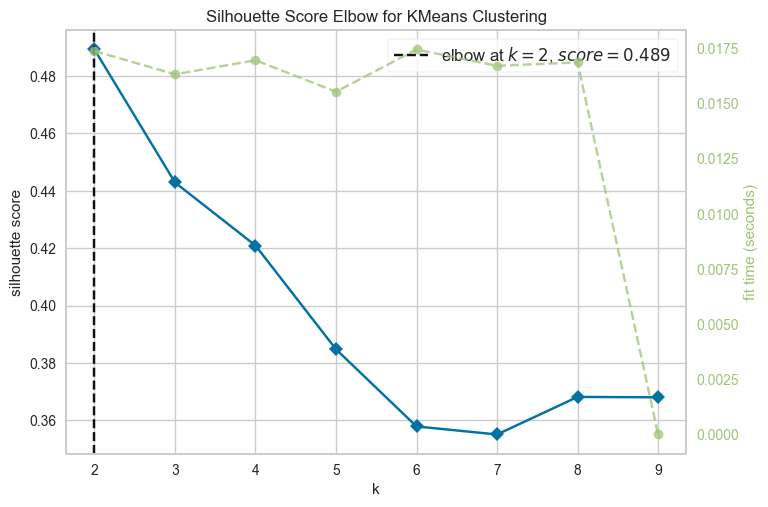

In [21]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_preprocessed)
visualizer.show()
plt.show()

In [22]:
kmeans_model = KMeans(n_clusters=3, random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', kmeans_model)
])

In [23]:
pipeline.fit(penguins)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['species', 'island',
                                                   'sex'])])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [24]:
penguins['cluster'] = pipeline['kmeans'].labels_

In [25]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,grupo,cluster
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,2


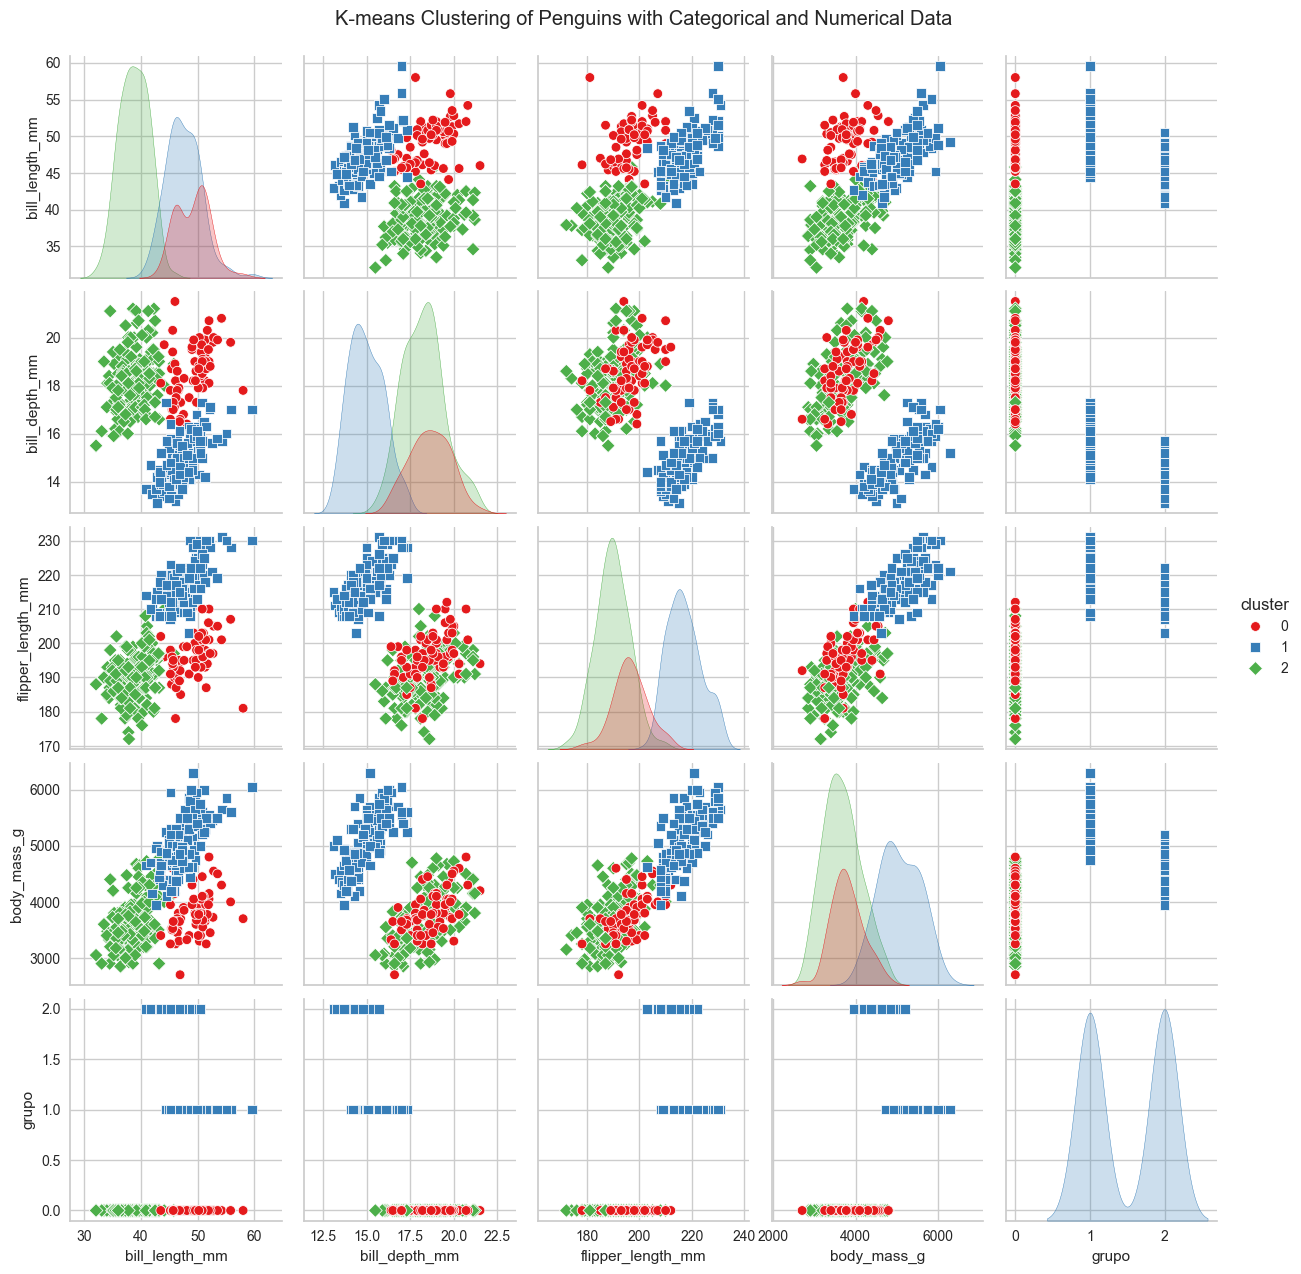

In [26]:
sns.pairplot(penguins, hue='cluster', palette='Set1', markers=["o", "s", "D"], diag_kind='kde')
plt.suptitle('K-means Clustering of Penguins with Categorical and Numerical Data', y=1.02)
plt.show()

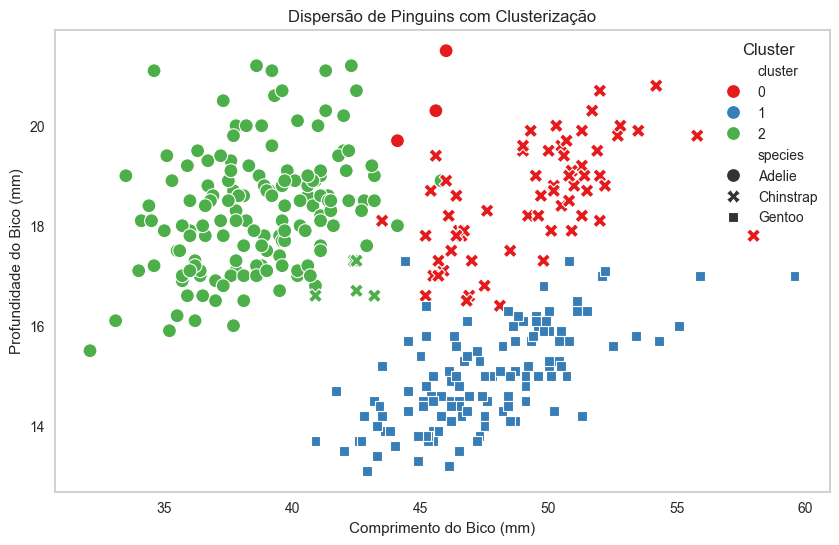

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=penguins, x='bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set1', style='species', s=100)
plt.title('Dispersão de Pinguins com Clusterização')
plt.xlabel('Comprimento do Bico (mm)')
plt.ylabel('Profundidade do Bico (mm)')
plt.legend(title='Cluster', loc='upper right')
plt.grid()
plt.show()  

In [28]:
crosstab = pd.crosstab(penguins['species'], penguins['cluster'], rownames=['Espécies'], colnames=['Cluster'])
crosstab

Cluster,0,1,2
Espécies,,,
Adelie,3,0,148
Chinstrap,63,0,5
Gentoo,0,123,0


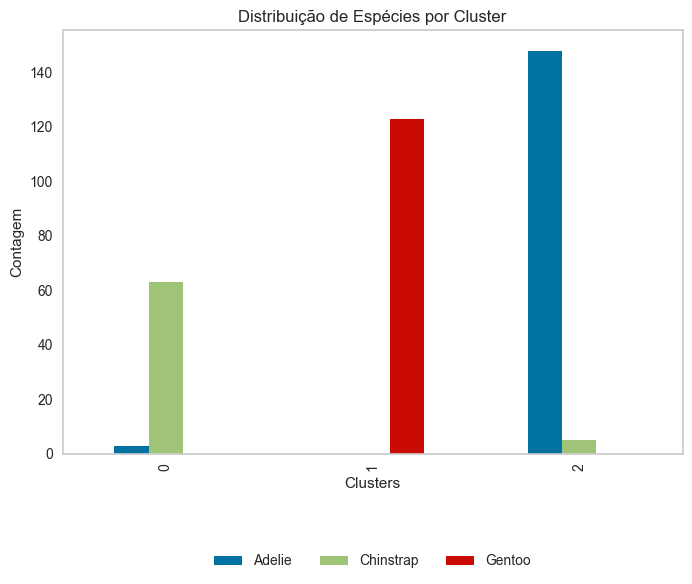

In [29]:
# Aqui 'y' será representado pela coluna 'species'
ax = penguins.groupby(['cluster', 'species'])['species'].count().unstack().plot.bar()

# Customizar a legenda conforme solicitado
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=3, fancybox=True, shadow=True)

# Exibir o gráfico
plt.title('Distribuição de Espécies por Cluster')
plt.xlabel('Clusters')
plt.ylabel('Contagem')
plt.grid()
plt.show()